In [26]:
import pandas as pd
# alternative visualizations
import seaborn as sns
import matplotlib.pyplot as plt
# multi enviroment work
import os
import platform
# to create data visualization
import altair as alt
# to create live graphs using different data
from ipywidgets import interact

sys = platform.system()
old_dir = os.getcwd()

# return a dataframe with all data since 2009
def getConcatenatedDF(who):
    os.chdir(old_dir)
    if (sys=='Darwin' or sys=='Linux'):
        os.chdir('./data/'+who)
    elif (sys =='Windows'):
        path= os.getcwd()
        if (who == 'Applications'):
            path+='\data\Applications'
            os.chdir(path)
        else:
            path+='\data\Registers'
            os.chdir(path)
    
    r = os.listdir()
    df= []
    for i in r:
        df.append(pd.DataFrame(pd.read_excel(i, sheet_name=0)))

    df = pd.concat(df)

    df["Year"] = df["ApplicationNumber"].astype(str).str[0:4]
    
    df = df[df["ApplicantRegion"].isin(["Maule", "Bío Bío", "Ñuble", "Libertador B. O'Higgins"])].copy()
    
    #always return to the main folder to prevent errors
    os.chdir(old_dir)
    return df

# first delete all (CL) and (%X) from applicants.
# Important: We will leave the marker .BR. to separate COLABORADORES   
def cleanDataApplicants(string):
    if (type(string)!= str):
    # deleting all nations viewed
        string = string.replace('(CL)', "")
        string = string.replace('(BR)', "")
        string = string.replace('(US)', " ") # this in specially is replaced with white space
    # to make sure we will use all percentages
    for i in range(101):
        if(i != 0):
            percentage = '('+str(i)+'%)'
            string = string.replace(percentage, "")
    # we will remove comma to standardize
    
    # also, we can change marker 
    string = string.replace('.BR.', "//a//")
    string = string.replace('BR ', "//a//")
    #some data have ; as separator
    string = string.replace(';', "//a//")
    # and then delete the dots
    string = string.replace('.', "")
    string = string.replace(',', "")
    
    # if you want to delete more, just add or create an array with characters to delete
    return string.upper() # return always in uppercase

In [27]:
# Global dataframes -- ⛔️⛔️⛔️ -- CAUTION: DO NOT OVERWRITE
df_macrozone = getConcatenatedDF('Applications')
df_macrozone2 = getConcatenatedDF('Registers')

#d = df[df["Applicants"].str.contains("UNIVERSIDAD DE CONCEPCION", regex=True, na=False)]
#d[d["ApplicantRegion"] == "No disponible"]


In [28]:
df_macrozone["Applicants"] = df_macrozone["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")

stats = df_macrozone.groupby(["ApplicantRegion", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()

population = [
    {"ApplicantRegion": "Libertador B. O'Higgins", "Population": 914555},
    {"ApplicantRegion": "Maule", "Population": 1044950},
    {"ApplicantRegion": "Ñuble", "Population": 480609},
    {"ApplicantRegion": "Bío Bío", "Population": 1556805}
]

df_population = pd.DataFrame(population)
df_population

df_agg = stats[stats["Year"].isin(["2017", "2018", "2019"])].groupby(["ApplicantRegion"]).agg({"ApplicationNumber": "mean"}).reset_index()

df_agg = df_agg.merge(df_population, on="ApplicantRegion")
df_agg["Per Capita"] = 100000 * df_agg["ApplicationNumber"] / df_agg["Population"]

df_agg

<ipython-input-28-2e5589cefa1e>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_macrozone["Applicants"] = df_macrozone["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")


,ApplicantRegion,ApplicationNumber,Population,Per Capita
0,Bío Bío,56.000000,1556805,3.597111
1,Libertador B. O'Higgins,9.666667,914555,1.056980
2,Maule,8.333333,1044950,0.797486
3,Ñuble,2.333333,480609,0.485495


Text(0.5, 0, 'Región')

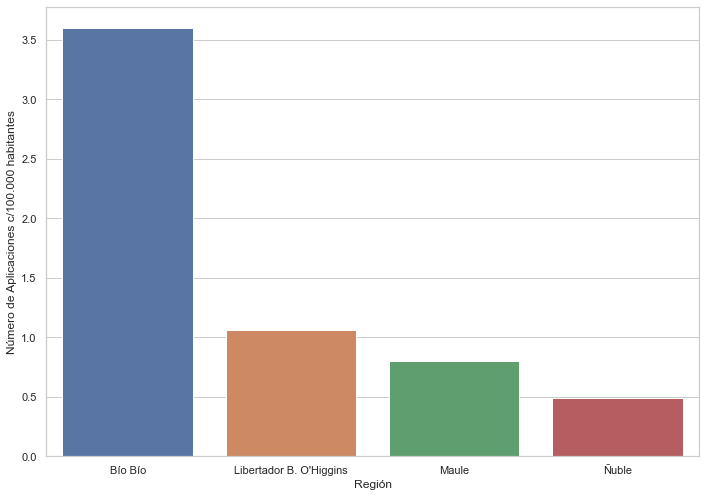

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style="whitegrid")
ax = sns.barplot(x="ApplicantRegion", y="Per Capita", data=df_agg)
ax.set_ylabel("Número de Aplicaciones c/100.000 habitantes")
ax.set_xlabel("Región")

In [30]:
#Se agrupan las solicitudes por solicitante y año, posteriormente obtenermos los solicitantes que por año realizaron más solicitudes

df_macrozone_top = df_macrozone

df_macrozone_top['Applicants'] = df_macrozone_top["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")

stats2 = df_macrozone_top.groupby(["Applicants", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()

df_top = stats2.sort_values('ApplicationNumber', ascending=False).head(20)



<ipython-input-30-170de2688616>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_macrozone_top['Applicants'] = df_macrozone_top["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")


# Nuevo bloque de Luis, creación de funciones que retorna dataFrame de solicitantes o registros

In [31]:
#En caso de querer saber acerca de los colaboradores, comentar data.groupby... por:
#data = data.groupby(["Applicants", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index() 
#Esto aplica para registers y applicants

#Las instituciones con más solicitudes son 
#"UNIVERSIDAD DE CONCEPCION","UNIVERSIDAD DEL BIO BIO","CONTENEDORES SAN FERNANDO SPA", "MARIO GUERRERO MENDEZ", "VICTOR MANUEL ROSALES ITURRA"

def data_applicants(inst):
    data = df_macrozone2[df_macrozone2["Applicants"].str.contains(inst, regex=True, na=False)]
    data = data.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    data = data.sort_values('Year', ascending=True)
    return data

def data_registers(inst):
    data = df_macrozone[df_macrozone["Applicants"].str.contains(inst, regex=True, na=False)]
    data = data.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    data = data.sort_values('Year', ascending=True)
    return data
    
def merge_data(inst):
    # mejoras de fandi
    a = data_applicants(inst)
    b = data_registers(inst)
    a = AddYears0(b , a)
    b = AddYears0(a , b)
    
    merged = pd.merge(a, b ,  on=['Year'])
    merged = merged.rename(columns={'ApplicationNumber_x':'Applicants',
                                   'ApplicationNumber_y':'Registers'})
    merged.insert(1, 'Applicant', inst, allow_duplicates=False)
    
    return merged
    
# improve merge. Add rows from dataframeB that doesn't exist in dataframeA
# Warning: use only once per dataframe -- or -- do only via merge_data function
def AddYears0(dataframeA , dataframeB):
    # to initiate dataframe
    add = pd.DataFrame([[1,2]], columns=['Year','ApplicationNumber'])
    for i in dataframeA.index:
        flag = True
        for j in dataframeB.index:
            #print(dataframeA['Year'].tolist()[i])
            if(dataframeA['Year'].tolist()[i] == dataframeB['Year'].tolist()[j]):
                #print('\t '+ dataframeB['Year'].tolist()[j] )
                flag = False
        if flag:
            row = pd.DataFrame([[dataframeA['Year'][i],0]], columns=['Year','ApplicationNumber'])
            #print(row)
            add = pd.concat([add,row])
    add = add[add["Year"] != 1]
    return pd.concat([add,dataframeB]).reset_index(drop=True)

In [32]:
#En merge_data usamos el parámetro que necesitamos de institucion: estos son por ejemplo
#"UNIVERSIDAD DE CONCEPCION","UNIVERSIDAD DEL BIO BIO","CONTENEDORES SAN FERNANDO SPA", "MARIO GUERRERO MENDEZ", "VICTOR MANUEL ROSALES ITURRA"
#var = merge_data('UNIVERSIDAD DEL BIO BIO')
#var
#Podríamos calcular tasas de aceptación, el problema es que si bien te acuerdas, los datos de los appicants desde el año 2013 en adelan te están incompletos
#Esto lo comprobamos ese día en donde vimos que en applicants de 2021 por ejemplo existen sólo 5 tuplas de datos

#La suma de los applicants y registers por año la comprobé y está correcta 
#Si quieres comprobarla debes añadir en la funcion agrupar que se agrupe por aplicant

In [33]:
'''
#only merge universidad de concepcion
# do tidy data 

tidy = pd.melt(frame=var, id_vars=['Applicant','Year'],
               value_vars=['Applicants','Registers'],
              var_name='Type', value_name='ApplicationNumber')
# idk if ApplicationNumber_x references to Register or Applicant, this is only a test to deploying data
def transform(aux):
    if (aux == 'Registers'):
        return 'Registro'
    return 'Solicitud'

tidy['Type'] = tidy['Type'].apply(transform)

tidy
'''

"\n#only merge universidad de concepcion\n# do tidy data \n\ntidy = pd.melt(frame=var, id_vars=['Applicant','Year'],\n               value_vars=['Applicants','Registers'],\n              var_name='Type', value_name='ApplicationNumber')\n# idk if ApplicationNumber_x references to Register or Applicant, this is only a test to deploying data\ndef transform(aux):\n    if (aux == 'Registers'):\n        return 'Registro'\n    return 'Solicitud'\n\ntidy['Type'] = tidy['Type'].apply(transform)\n\ntidy\n"

# Punto 1 a corregir

In [34]:
#Color scheme to select:
#  accent, dark2, paired, pastel1, set1, set2, set3

'''
grafico = alt.Chart(tidy).mark_bar().encode(
    x=alt.X('Type:O', title=None, axis=None),
    y=alt.Y('ApplicationNumber:Q', title=None),
    color=alt.Color('Type:N', legend=alt.Legend(title="Tipo"), scale=alt.Scale(scheme='set1')),
    column=alt.Column('Year:N', header=alt.Header(title=None))
).properties(
    title=(["Conteo de Registros/Solicitudes de Patentes", tidy['Applicant'].tolist()[0]])
)
'''
# Las cpnfiguraciones se hacen al final cuando se juntan los graficos

#    Hacer este mismo gráfico pero para cada region
# ✅ Quitar las etiquetas en la parte de abajo de applicant y register ya que es innesesario al estar en colore 
# ✅ La etiqueta type abajo de applicant y register también es innecesaria ya que está en la esquina superior derecha
# ✅ Pasar las etiquetas a español
# ✅ Dar más cariño en los tamaños de letra, aprovechar mejor el espacio
# ❌ Utilizar MatplotLib o seaborn si queremos
# ❌ Tener cuidado en que el register tenga más que los applicants, esto pasaba porque esta data no consideraba los colaboradores
# ✅ Pero en sí le gustaron a Carlos Navarrete este gráfico 

#grafico

'\ngrafico = alt.Chart(tidy).mark_bar().encode(\n    x=alt.X(\'Type:O\', title=None, axis=None),\n    y=alt.Y(\'ApplicationNumber:Q\', title=None),\n    color=alt.Color(\'Type:N\', legend=alt.Legend(title="Tipo"), scale=alt.Scale(scheme=\'set1\')),\n    column=alt.Column(\'Year:N\', header=alt.Header(title=None))\n).properties(\n    title=(["Conteo de Registros/Solicitudes de Patentes", tidy[\'Applicant\'].tolist()[0]])\n)\n'

# Punto 1: Corregido ✅ ✅
## Las dos siguientes celdas muestran los datos separados por región

In [35]:
# First we need split df_macrozone and df_macrozone2
zone_list = ['Bío Bío','Maule','Ñuble',  "Libertador B. O'Higgins"]

def transform(aux):
    if (aux == 'Registers'):
        return 'Registro'
    return 'Solicitud'

def get_zone(zone_name, inst):
    # Obtain subset from zone_name
    zone_applications = df_macrozone[df_macrozone["ApplicantRegion"] == zone_name]
    zone_applications = zone_applications[zone_applications["Applicants"].str.contains(inst, regex=True, na=False)]
    zone_applications = zone_applications.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    zone_applications = zone_applications.sort_values('Year', ascending=True)
    
    zone_registers = df_macrozone2[df_macrozone2["ApplicantRegion"] == zone_name]
    zone_registers = zone_registers[zone_registers["Applicants"].str.contains(inst, regex=True, na=False)]
    zone_registers = zone_registers.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    zone_registers = zone_registers.sort_values('Year', ascending=True)
    
    # Create data with 0 if it doesn't exist in one or another dataframe
    #zone_applications = AddYears0(zone_registers ,zone_applications )
    #zone_registers = AddYears0(zone_applications , zone_registers)
    
    # Merge Dataframes 
    merged = pd.merge(zone_applications, zone_registers ,  on=['Year'])
    merged = merged.rename(columns={'ApplicationNumber_x':'Applicants',
                                   'ApplicationNumber_y':'Registers'})
    merged.insert(1, 'Applicant', inst, allow_duplicates=False)
    
    # Do tidy to deploy correctly
    tidy = pd.melt(frame=merged, id_vars=['Applicant','Year'],
                   value_vars=['Applicants','Registers'],
                  var_name='Type', value_name='ApplicationNumber')
    tidy['Type'] = tidy['Type'].apply(transform)
    
    if (len(tidy['Applicant'].tolist()) == 0):
        #print ("no hay data para region de "+ zone_name)
        return None
    
    # now we are available to deploy data on chart
    
    grafico = alt.Chart(tidy).mark_bar().encode(
    x=alt.X('Type:O', title=None, axis=None),
    y=alt.Y('ApplicationNumber:Q', title=None),
    color=alt.Color('Type:N', legend=alt.Legend(title="Tipo"), scale=alt.Scale(scheme='set1')),
    column=alt.Column('Year:N', header=alt.Header(title=None))
    ).properties(
        title=[zone_name,""]
    )
    
    return grafico

def getZonesChartsByInstitution(institucion):
    charts= []
    for aux in zone_list:
        p_chart = get_zone(aux,institucion)
        if (p_chart):
            charts.append(p_chart)

    # solución parche para mostrar los datos dependiendo de como vengan
    if (len(charts)== 1):
        deploy = alt.hconcat(charts[0]
                            ).resolve_scale(y='shared') 
    elif (len(charts)== 2):
        deploy = alt.hconcat(charts[0],charts[1]
                            ).resolve_scale(y='shared')
    elif (len(charts)== 3):
        deploy = alt.hconcat(charts[0],charts[1]
                            ).resolve_scale(y='shared') & alt.hconcat(charts[2]
                                                                     ).resolve_scale(y='shared')
    elif (len(charts)== 4):
        deploy = alt.hconcat(charts[0],charts[1]
                            ).resolve_scale(y='shared') & alt.hconcat(charts[2],charts[3]
                                                                     ).resolve_scale(y='shared')    
    return deploy.configure_legend(
        titleFontSize=18,
        labelFontSize=14
    ).configure_title(
        fontSize=20,
        font='Courier',
        anchor='middle',
        color='gray'
    ).properties(
        title=(["Registros vs Solicitudes de Patentes", institucion, "   "])
    )

In [36]:
# YOU CAN ADD MANUALY OR CONSULT toConcatenate DATAFRAME WITH COLABORATORS

lista_instituciones = ['UNIVERSIDAD DE CONCEPCION', 'UNIVERSIDAD DEL BIO BIO', 
                       'UNIVERSIDAD DE TALCA','UNIVERSIDAD DE LA SERENA',
                       'UNIVERSIDAD CATOLICA DE TEMUCO']

interact(getZonesChartsByInstitution, institucion= lista_instituciones)

interactive(children=(Dropdown(description='institucion', options=('UNIVERSIDAD DE CONCEPCION', 'UNIVERSIDAD D…

<function __main__.getZonesChartsByInstitution(institucion)>

# Punto 2 a corregir  

## Corregido ✅

### Gráficos de conteo por Región

#### Conteo para Applicants

In [52]:
# only use df_macrozone for Registers -- dont need clean data
chart = alt.Chart(df_macrozone2).mark_bar().encode(
    x=alt.X('Year:O', title=None),
    y=alt.Y('count()', title='Solicitudes'),
    color = alt.Color('ApplicantRegion:N', legend=alt.Legend(title=[]"Solicitudes por Región"), scale=alt.Scale(scheme='dark2')),
    tooltip = [alt.Tooltip ('Year'),alt.Tooltip('ApplicantRegion', title='Región'),
               alt.Tooltip('count()',title = 'N° de Applicants')]
).configure_legend(
    titleFontSize=18,
    labelFontSize=14
).configure_axis(
    labelFontSize=14,
    titleFontSize=16
).configure_title(
    fontSize=20,
    font='Courier',
    anchor='middle',
    color='gray'
)

chart

# ✅ Quitar la etiqueta YEAR porque es innesearia

# ✅ La etiqueta del eje y que diga solicitudes

# ✅ Cambiar título de leyenda

# ✅ Más grande las etiquetas 

# ❌ Poner una linea o salto con 2019 y 2020 (Este es opcional, esto me dijo que se hacía cuando no teníamos certeza de los datos, por ejemplo en 2019 y 2020 hay pocos datos y es bastante probable que esa data esté mala o incompleta)

# ❌ Revisar bien data 2020 porque hay pocos datos 

alt.Chart(...)

# Franco

#### Este bloque reemplaza df_macrozone (applications) por un dataframe que contiene todos los applicants por separado, manteniedo sus parametros de año. Tienen una diferencia de 100 tuplas (rows)

In [38]:
# use cleanDataApplicants() to standarize names
df_macrozone_copy = df_macrozone
df_macrozone_copy['Applicants'] = df_macrozone_copy['Applicants'].apply(cleanDataApplicants)
df_macrozone_copy = df_macrozone_copy.sort_values('Year', ascending=True)

columnas = ['ApplicationNumber','Applicants', 'Year']

# to initiate dataframe
toConcatenate = pd.DataFrame([[1,2,3]], columns=columnas)
# iterate dataframe 
for i in df_macrozone_copy.index:    
    if (type(df_macrozone_copy['Applicants'][i]) == str):
        for aux in  df_macrozone_copy['Applicants'][i].split('//A//'):
            #print('\t '+aux)
            
            if (aux.find("//A//") != -1):
                print(aux) # me estoy asegurando que la data fue bien separada
                
            row = pd.DataFrame([[df_macrozone_copy['ApplicationNumber'][i],aux.strip(), df_macrozone_copy['Year'][i]]], columns=columnas)
            toConcatenate = pd.concat([toConcatenate, row])
    else:
        for aux2 in range(len(df_macrozone_copy['Applicants'][i])):
            aux_AN = df_macrozone_copy['ApplicationNumber'][i].tolist()[aux2]
            aux_Ap = df_macrozone_copy['Applicants'][i].tolist()[aux2].strip()
            aux_Year = df_macrozone_copy['Year'][i].tolist()[aux2]
            if (aux_Ap.find("//A//") != -1): #significa que existen separadores y por tanto se deben separar
                for aux3 in aux_Ap.split('//A//'):
                    row = pd.DataFrame([[aux_AN,aux3, aux_Year]], columns=columnas)
                    toConcatenate = pd.concat([toConcatenate, row])
            else:
                row = pd.DataFrame([[aux_AN,aux_Ap, aux_Year]], columns=columnas)
                toConcatenate = pd.concat([toConcatenate, row])

#deleting first row 
toConcatenate = toConcatenate[toConcatenate["Applicants"] != 2]
print(len(toConcatenate))
print(len(df_macrozone_copy))
toConcatenate


689
596


,ApplicationNumber,Applicants,Year
0,200900849,(CL) CONTENEDORES SAN FERNANDO SPA,2009
0,200901995,(CL) CONTRERAS SEGUEL RODRIGO,2009
0,201301875,(CL) UNIVERSIDAD DE CONCEPCION,2013
0,200902035,(CL) ERNESTO REINALDO BEAS BUSTOS,2009
0,201201932,(CL) ACUNA SALAZAR FELIPE RENAN,2012
...,...,...,...
0,202100206,(CL) LUIS FELIPE LOBOS ALVAREZ,2021
0,202100272,(CL) INVESTIGACIONES FORESTALES BIOFOREST SA,2021
0,202100634,(CL) UNIVERSIDAD DE TALCA,2021
0,202100705,(CL) CONTENEDORES SAN FERNANDO SPA,2021


# Punto 3 corregir

In [39]:
# now we are available to work with data separated
data = toConcatenate[toConcatenate["Applicants"].str.contains("UNIVERSIDAD DE CONCEPCION", regex=True, na=False)]
data = data.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
data = data.sort_values('Year', ascending=True)

g1 = alt.Chart(data).mark_bar().encode(
    x='Year:O',
    y='ApplicationNumber:Q',
)


g2 = alt.Chart(data_registers('UNIVERSIDAD DE CONCEPCION')).mark_bar().encode(
    x='Year:O',
    y='ApplicationNumber:Q',
)

g1 | g2

#to prove both methods works same


# Realizar este gráfico similar al primero que hicimos 


#Tener cuidado con que los colaboras se cuenten una sóla vez

alt.HConcatChart(...)

In [40]:
(toConcatenate['Applicants'].unique().tolist())

['(CL) CONTENEDORES SAN FERNANDO SPA',
 '(CL) CONTRERAS SEGUEL RODRIGO',
 '(CL) UNIVERSIDAD DE CONCEPCION',
 '(CL) ERNESTO REINALDO BEAS BUSTOS',
 '(CL) ACUNA SALAZAR FELIPE RENAN',
 '(CL) CLAUDIO ANDRES GUTIERREZ HERMOSILLA',
 '(CL) ES DISENO LIMITADA',
 '(CL) BIO INSUMOS NATIVA SPA',
 '(CL) DIAZ MUNOZ SANDRO RIGOBERTO',
 '(CL) AGVISION SA',
 '(CL) DISENO CAPITAL LTDA BR(CL) GREENHILL BARRIGA MARGARET',
 '(CL) INDUSTRIAS CHILENAS DE ALAMBRE INCHALAM SA',
 '(CL) MARIA JOSE COFRE GAETE',
 '(CL) GLORIA IVETTE LEIVA BURGOS',
 '(CL) CARLOS ROA LARENAS',
 '(CL) TRANSPORTES CONGUILLIO LTDA',
 '(CL) CARRENO SUAZO CARMEN CECILIA',
 '(CL) VERA MARCHANT JOSE VICTOR',
 '(CL) CELULOSA ARAUCO Y CONSTITUCION SABR(CL) UNIVERSIDAD DE CONCEPCION',
 '(CL) SANCHEZ RIQUELME EDUARDO ANDRES',
 '(CL) COMERCIAL JM EIRL',
 '(CL) GODOY MUNOZ HECTOR',
 '(CL) CANALES GONZALEZ CARLOS ENRIQUE',
 '(CL) COMPANIA PATENTES DEL PACIFICO SPA',
 '(CL) CARDENAS Y COMPANIA LTDA',
 '(CL) SOCIEDAD DE HORMIGONES Y BALDOSAS Y C

In [41]:
def getGraficofromCleanData(Applicant):
    # now we are available to work with data separated
    data = toConcatenate[toConcatenate["Applicants"].str.contains(Applicant, regex=True, na=False)]
    data = data.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    data = data.sort_values('Year', ascending=True)

    g1 = alt.Chart(data).mark_bar().encode(
        x='Year:O',
        y='ApplicationNumber:Q',
    )
    return g1

In [42]:
k = toConcatenate['Applicants'].unique().tolist()
k.sort()


interact(getGraficofromCleanData, Applicant= k )

interactive(children=(Dropdown(description='Applicant', options=('(BR) FUNDACAO EDSON QUEIROZ - UNIVERSIDAD DE…

<function __main__.getGraficofromCleanData(Applicant)>

## More Visualizations

In [43]:
data = toConcatenate[toConcatenate["Applicants"].str.contains('UNIVERSIDAD DEL BIO BIO', regex=True, na=False)]
data = data.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
data = data.sort_values('Year', ascending=True)

alt.Chart(data).mark_area(
    interpolate='step-after',
    line=True
).encode(
    x='Year',
    y='ApplicationNumber'
)| alt.Chart(data).mark_line().encode(
    alt.X('Year:O'),
    alt.Y('ApplicationNumber:Q', axis=alt.Axis(format='%'))
)



alt.HConcatChart(...)

In [44]:
#Ahora tenemos que crear un doc de no más de 2 o 3 planas explciando los gráficos realizados, mostrar y explicar la metodología, ver y explicar el código, es como tomar todo lo que hicimos y explicar qué hicimos, por ejemplo, tomamos los br y los separamos por ... etc 
#Crearlo en un google docs 
#Agregar a este documento el total de patentes de la macrozona por año y después de esto el per capita por region y luego los gráficos de nosotros
#Al final explicar el top 5 de patentes aplicados a la macrozona 


In [45]:
print(len(df_macrozone))
len(df_macrozone['ApplicationNumber'].unique())

596


596

In [46]:
aux = df_macrozone[df_macrozone['ApplicantRegion'] == 'Ñuble']

aux = aux[aux["Applicants"].str.contains('UNIVERSIDAD DEL BIO BIO', regex=True, na=False)]

aux

,ApplicationNumber,RegistrationNumber,Applicants,Representatives,Inventors,FilingDate,PublicationDate,RegistrationDate,ExpirationDate,Title,...,SubtypeName,Status,Country,ApplicantRegion,RepresentativeRegion,PCTApplicationDate,PCTPublicationDate,Priorities,LastUpdatedDate,Year


In [47]:
zone_list

['Bío Bío', 'Maule', 'Ñuble', "Libertador B. O'Higgins"]

In [48]:
df_macrozone2.columns

Index(['ApplicationNumber', 'RegistrationNumber', 'Applicants',
       'Representatives', 'Inventors', 'FilingDate', 'PublicationDate',
       'RegistrationDate', 'ExpirationDate', 'Title', 'TypeName',
       'SubtypeName', 'Status', 'Country', 'ApplicantRegion',
       'RepresentativeRegion', 'PCTApplicationDate', 'PCTPublicationDate',
       'Priorities', 'LastUpdatedDate', 'Year'],
      dtype='object')

In [49]:
aux = df_macrozone2[df_macrozone2['Status'].isin(["Registrada"])].copy()


aux = aux.groupby(['ApplicantRegion','TypeName'])\
      .agg({'ApplicationNumber': 'count'}).reset_index()

aux = aux.rename(columns={'ApplicantRegion': 'Región', 'TypeName':'Area', 'ApplicationNumber':'patentes vigentes'})

aux

,Región,Area,patentes vigentes
0,Bío Bío,Dibujo o Diseño Industrial,6
1,Bío Bío,Modelo de Utilidad,14
2,Bío Bío,Patente de Invención,201
3,Libertador B. O'Higgins,Dibujo o Diseño Industrial,3
4,Libertador B. O'Higgins,Modelo de Utilidad,1
5,Libertador B. O'Higgins,Patente de Invención,26
6,Maule,Dibujo o Diseño Industrial,2
7,Maule,Modelo de Utilidad,1
8,Maule,Patente de Invención,19
9,Ñuble,Patente de Invención,8


In [50]:
df_macrozone2['Status'].unique()

array(['Registrada', 'Caducada', 'En trámite', 'Anulada'], dtype=object)